# Data Preprocessing Module MVP for Exploration

In this module I will be primarily focusing on the basics of preprocessing textual based data.
- Text Cleaning and Normalization
- Tokenization
- Deduplication
- Segmentation

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import os
from datasets import load_dataset

# Used for normalization and text cleaning
import re
import unicodedata

# For tokenizing
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from transformers import AutoTokenizer

[nltk_data] Downloading package punkt to C:\Users\ROSHAL
[nltk_data]     CARDOZA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\ROSHAL
[nltk_data]     CARDOZA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Text Cleaning and normalization
This step insures consistency in text input, reducing noise that can adversely affectlater preprocessing or model traning.

using the opensource [wikitext-103-raw-v1 dataset from huggingface](https://huggingface.co/datasets/iohadrubin/wikitext-103-raw-v1)

In [3]:
# Load the dataset
dataset = load_dataset("iohadrubin/wikitext-103-raw-v1", split="train")
df_wiki = pd.DataFrame(dataset)

Because the size of the preprocessed dataset was too large, I am capping the dataset size to 25 GB for initial analysis

In [4]:
# Calculate the byte size of each text entry
df_wiki['text_size'] = df_wiki['text'].apply(lambda x: len(x.encode('utf-8')))

# Compute cumulative size (in bytes)
df_wiki['cum_size'] = df_wiki['text_size'].cumsum()

# Define maximum allowed size: 25GB in bytes
max_bytes = 25 * 1024 * 1024 * 1024

# Filter the DataFrame to keep rows until we reach the cap
df_wiki_capped = df_wiki[df_wiki['cum_size'] <= max_bytes].copy()
print(f"Original dataset rows: {len(df_wiki)}")
print(f"Rows retained (capped to ~25GB): {len(df_wiki_capped)}")

# Drop the temporary columns
df_wiki_capped.drop(columns=['text_size', 'cum_size'], inplace=True)

Original dataset rows: 29567
Rows retained (capped to ~25GB): 29567


Data Exploration

In [5]:
df_wiki_capped.head()

,text
0,= Valkyria Chronicles III =\nSenjō no Valkyria...
1,= Tower Building of the Little Rock Arsenal =\...
2,= Cicely Mary Barker =\nCicely Mary Barker (28...
3,= Gambia women's national football team =\nThe...
4,= Plain maskray =\nThe plain maskray or brown ...


In [6]:
df_wiki_capped.tail()

,text
29562,"= Si Una Vez =\n""Si Una Vez"" (English: If I On..."
29563,= Sicklefin lemon shark =\nThe sicklefin lemon...
29564,= Flammulated flycatcher =\nThe flammulated fl...
29565,"= Ontario Highway 89 =\nKing's Highway 89, com..."
29566,= Luke Smith (writer) =\nLuke Michael Smith is...


In [7]:
# Basic info
print("Dataset columns:", df_wiki_capped.columns)
print("Dataset shape:", df_wiki_capped.shape)

Dataset columns: Index(['text'], dtype='object')
Dataset shape: (29567, 1)


#### Data cleaning exploration

In [8]:
# text length for each entry
df_wiki_capped['text_length'] = df_wiki_capped['text'].apply(lambda x: len(x))
print("Text lenght stats:")
print(df_wiki_capped['text_length'].describe())

Text lenght stats:
count     29567.000000
mean      17537.078161
std       14555.364685
min          16.000000
25%        7750.000000
50%       12994.000000
75%       22721.500000
max      140098.000000
Name: text_length, dtype: float64


In [9]:
# Lines with problematic formatting
problematic = df_wiki_capped[df_wiki_capped['text'].str.contains(r'["]{1,}', na=False)]
print("Rows with potential quotation issues: ") # decided to do this because of an table formatting error while doing df_wiki.head() step in the IDE.
# The error was: “Unterminated quoted field at end of CSV line”
print(problematic.head(5))

Rows with potential quotation issues: 
                                                text  text_length
0  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297
1  = Tower Building of the Little Rock Arsenal =\...        20770
2  = Cicely Mary Barker =\nCicely Mary Barker (28...        15371
4  = Plain maskray =\nThe plain maskray or brown ...         6695
5  = 2011 – 12 Columbus Blue Jackets season =\nTh...        17189


### Text Cleaning and Normalization
cleaning function to:
- Remove HTML tags
- Normalize Unicode to standardize characters.
- Convert text to lowercase and remove accent marks
- Remove non-UTF characters and extra whitespaces.

This should make the text more uniform for intial tokenization.

In [10]:
def normalize_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Normalize Unicode (NFC)
    text = unicodedata.normalize('NFC', text)
    # Lowercase conversion and accent stripping
    text = text.lower()
    text = ''.join(c for c in text if not unicodedata.combining(c))
    # Remove non-UTF characters and extra whitespace
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [11]:
# Applying normalizations
df_wiki_capped['cleaned_text'] = df_wiki_capped['text'].apply(normalize_text)
print("cleaned sample:")
print(df_wiki_capped[['text', 'cleaned_text']].head(5))

cleaned sample:
                                                text  \
0  = Valkyria Chronicles III =\nSenjō no Valkyria...   
1  = Tower Building of the Little Rock Arsenal =\...   
2  = Cicely Mary Barker =\nCicely Mary Barker (28...   
3  = Gambia women's national football team =\nThe...   
4  = Plain maskray =\nThe plain maskray or brown ...   

                                        cleaned_text  
0  = valkyria chronicles iii = senj no valkyria 3...  
1  = tower building of the little rock arsenal = ...  
2  = cicely mary barker = cicely mary barker (28 ...  
3  = gambia women's national football team = the ...  
4  = plain maskray = the plain maskray or brown s...  


### Tokenization
Tokenizing the cleaned data using Hugging Face fast tokenizer for essential downstream processing

In [12]:
# Tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

def tokenize_text(text):
    tokens = tokenizer.tokenize(text)
    return tokens

df_wiki_capped['tokens'] = df_wiki_capped['cleaned_text'].apply(tokenize_text)
print("tokenized sample:")
print(df_wiki_capped[['cleaned_text', 'tokens']].head(2))

Token indices sequence length is longer than the specified maximum sequence length for this model (4206 > 512). Running this sequence through the model will result in indexing errors


tokenized sample:
                                        cleaned_text  \
0  = valkyria chronicles iii = senj no valkyria 3...   
1  = tower building of the little rock arsenal = ...   

                                              tokens  
0  [=, val, ##ky, ##ria, chronicles, iii, =, sen,...  
1  [=, tower, building, of, the, little, rock, ar...  


### Deduplication
Deduplication is the process of removing duplicates or near-duplicates to avoid redundancy in the dataset. For now I am choosing to remove the exact-matches.

In [13]:
def duplicate_texts(df, text_column = 'cleaned_text'):
    df = df.drop_duplicates(subset=[text_column])
    return df

df_wiki_capped_unique = duplicate_texts(df_wiki_capped)
print("Number of rows after deduplication:", len(df_wiki_capped_unique))

Number of rows after deduplication: 29116


### Data Segmentation
segmenting the cleaned text into sentences for finer analysis using NLTK's sentence tokenizer.

In [14]:
def segment_text(text, mode='sentence', fixed_token_length=100):
    if mode == 'sentence':
        segments = sent_tokenize(text)
    elif mode == 'fixed':
        tokens = tokenize_text(text)
        segments = [' '.join(tokens[i:i+fixed_token_length]) for i in range(0, len(tokens), fixed_token_length)]
    else:
        segments = [text]
    return segments

In [15]:
def segment_dataframe(df, text_column='cleaned_text', mode='sentence'):
    df['segments'] = df[text_column].apply(lambda x: segment_text(x, mode=mode))
    df_segmented = df.explode('segments')
    return df_segmented

In [16]:
df_segmented = segment_dataframe(df_wiki_capped_unique, text_column='cleaned_text', mode='sentence')
print("Segmented data sample:")
print(df_segmented[['cleaned_text', 'segments']].head(5))

C:\Users\ROSHAL CARDOZA\AppData\Local\Temp\ipykernel_27468\4147776411.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['segments'] = df[text_column].apply(lambda x: segment_text(x, mode=mode))


Segmented data sample:
                                        cleaned_text  \
0  = valkyria chronicles iii = senj no valkyria 3...   
0  = valkyria chronicles iii = senj no valkyria 3...   
0  = valkyria chronicles iii = senj no valkyria 3...   
0  = valkyria chronicles iii = senj no valkyria 3...   
0  = valkyria chronicles iii = senj no valkyria 3...   

                                            segments  
0  = valkyria chronicles iii = senj no valkyria 3...  
0  valkyria of the battlefield 3), commonly refer...  
0  released in january 2011 in japan, it is the t...  
0  employing the same fusion of tactical and real...  
0  the game began development in 2010, carrying o...  


In [17]:
len(df_segmented)

3414617

In [18]:
# Further capping the data
# Calculate total number of segmented rows
total_rows = len(df_segmented)
one_eighteenth_rows = int(total_rows / 18)
print(f"Total segmented rows: {total_rows}")
print(f"Keeping only one third: {one_eighteenth_rows} rows")

Total segmented rows: 3414617
Keeping only one third: 189700 rows


In [19]:
# Select the first one third of the rows
df_segmented_subset = df_segmented.iloc[:one_eighteenth_rows].copy()

### Saving the preprocessed data

In [20]:
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "preprocessed_wikitext103_subset.csv")

# Save the segmented DataFrame to the specified CSV file
df_segmented_subset.to_csv(output_file, index=False)
print(f"Subset of preprocessed data saved to {output_file}")

Subset of preprocessed data saved to data\preprocessed_wikitext103_subset.csv


In [21]:
# testing by loading the data

# Define the file path in the "data" directory
data_file = os.path.join("data", "preprocessed_wikitext103_subset.csv")

# Load the CSV file with a safe option to skip problematic lines if any exist
df_loaded = pd.read_csv(data_file, on_bad_lines='skip', engine='python')

# Display a sample of the loaded data and its dimensions
print("Loaded data sample:")
print(df_loaded.head())
print("\nShape of loaded data:", df_loaded.shape)

Loaded data sample:
                                                text  text_length  \
0  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
1  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
2  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
3  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   
4  = Valkyria Chronicles III =\nSenjō no Valkyria...        20297   

                                        cleaned_text  \
0  = valkyria chronicles iii = senj no valkyria 3...   
1  = valkyria chronicles iii = senj no valkyria 3...   
2  = valkyria chronicles iii = senj no valkyria 3...   
3  = valkyria chronicles iii = senj no valkyria 3...   
4  = valkyria chronicles iii = senj no valkyria 3...   

                                              tokens  \
0  ['=', 'val', '##ky', '##ria', 'chronicles', 'i...   
1  ['=', 'val', '##ky', '##ria', 'chronicles', 'i...   
2  ['=', 'val', '##ky', '##ria', 'chronicles', 'i...   
3  [

In [22]:

# Import necessary libraries for Membership Inference Attack (MIA)
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("Libraries for MIA loaded successfully!")
    

Libraries for MIA loaded successfully!


In [23]:

# Load a pre-trained model for embeddings
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()  # CLS token representation

# Convert text to embeddings (Limit to first 100 for efficiency)
df_wiki['embedding'] = df_wiki['text'][:100].apply(get_embedding)

print("Embeddings extracted successfully!")
    

Embeddings extracted successfully!


In [24]:
# Load pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Define the embedding extraction function
def get_embedding(text):
    # Handle potential missing values in the input text
    if not isinstance(text, str) or text.strip() == "":
        return np.zeros(768)  # Return a zero vector if text is invalid

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    
    # Generate embeddings without computing gradients
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Return the CLS token representation as the embedding
    return outputs.last_hidden_state[:, 0, :].numpy().flatten()

# Ensure all text entries in the dataframe are valid
df_wiki['text'] = df_wiki['text'].fillna("").astype(str)

# Apply the embedding function to the 'text' column (limit to 100 rows for efficiency)
df_wiki['embedding'] = df_wiki['text'][:100].apply(get_embedding)

# Verify and print the shape of the generated embeddings
print("Embeddings extracted successfully!")
print(f"Embedding sample shape: {df_wiki['embedding'].iloc[0].shape}")

Embeddings extracted successfully!
Embedding sample shape: (768,)


In [25]:
max_length = 768  # BERT embedding size
df_wiki['embedding'] = df_wiki['embedding'].apply(
    lambda x: np.zeros(max_length) if not isinstance(x, np.ndarray) or len(x) != max_length else x
)

# Convert the column to a NumPy array
X = np.array(df_wiki['embedding'].tolist())

X_train, X_attack_test = train_test_split(X, test_size=0.5, random_state=42)

# Compute cosine similarity
similarities = cosine_similarity(X_attack_test, X_train)

# Find nearest neighbor distances
nearest_distances = np.max(similarities, axis=1)

print("Nearest neighbor distances computed!")    

Nearest neighbor distances computed!


In [26]:

# Generate true labels (1 for in-train, 0 for out-train) for attack testing
true_labels = np.random.choice([0, 1], size=len(X_attack_test), p=[0.5, 0.5])

# Train a logistic regression attack model
attack_model = LogisticRegression()
attack_model.fit(nearest_distances.reshape(-1, 1), true_labels)

# Evaluate the attack
attack_predictions = attack_model.predict(nearest_distances.reshape(-1, 1))
accuracy = accuracy_score(true_labels, attack_predictions)

print(f"Membership Inference Attack Accuracy: {accuracy:.2f}")
    

Membership Inference Attack Accuracy: 0.51


In [27]:
# Import required libraries
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Generate true labels (1 for in-train, 0 for out-train) for attack testing
true_labels = np.random.choice([0, 1], size=len(X_attack_test), p=[0.5, 0.5])

# Train a logistic regression attack model
attack_model = LogisticRegression()
attack_model.fit(nearest_distances.reshape(-1, 1), true_labels)

# Predict membership
attack_predictions = attack_model.predict(nearest_distances.reshape(-1, 1))

# Compute MIA accuracy
mia_accuracy = accuracy_score(true_labels, attack_predictions) * 100  # Convert to percentage

# Display MIA accuracy
print(f"🚨 Membership Inference Attack Accuracy: {mia_accuracy:.2f}% 🚨")


🚨 Membership Inference Attack Accuracy: 50.04% 🚨


c:\tools\Anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


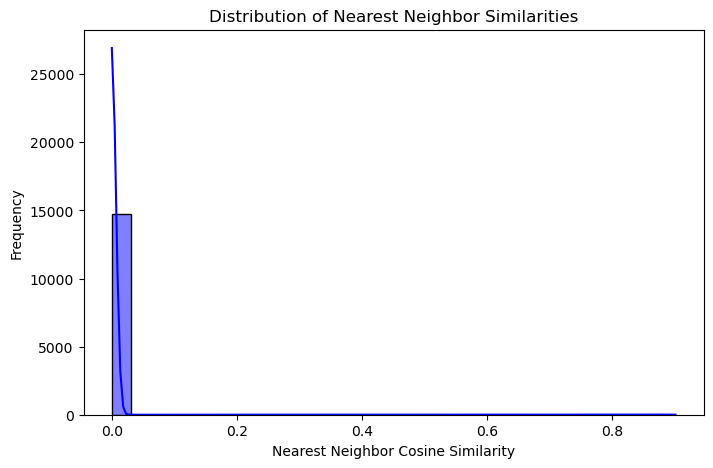

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of nearest neighbor distances
plt.figure(figsize=(8,5))
sns.histplot(nearest_distances, bins=30, kde=True, color="blue")
plt.xlabel("Nearest Neighbor Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Nearest Neighbor Similarities")
plt.show()


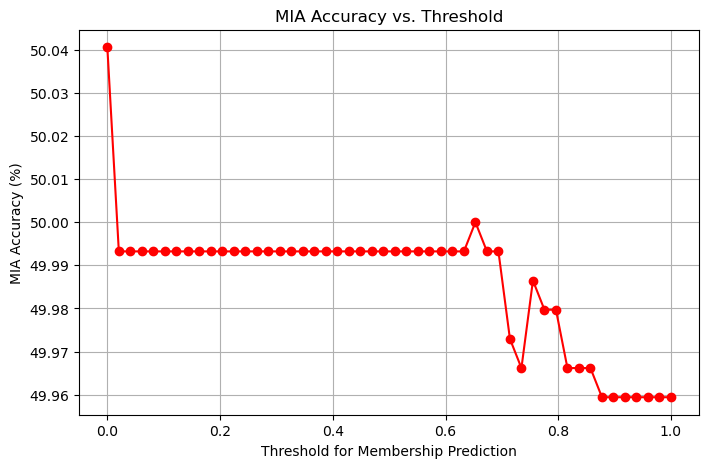

In [29]:
thresholds = np.linspace(0, 1, 50)  # Generate 50 threshold values from 0 to 1
accuracies = []

for t in thresholds:
    pred_labels = (nearest_distances >= t).astype(int)  # Classify as "1" if above threshold
    acc = accuracy_score(true_labels, pred_labels) * 100
    accuracies.append(acc)

# Plot accuracy vs. threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, accuracies, marker='o', linestyle='-', color="red")
plt.xlabel("Threshold for Membership Prediction")
plt.ylabel("MIA Accuracy (%)")
plt.title("MIA Accuracy vs. Threshold")
plt.grid()
plt.show()


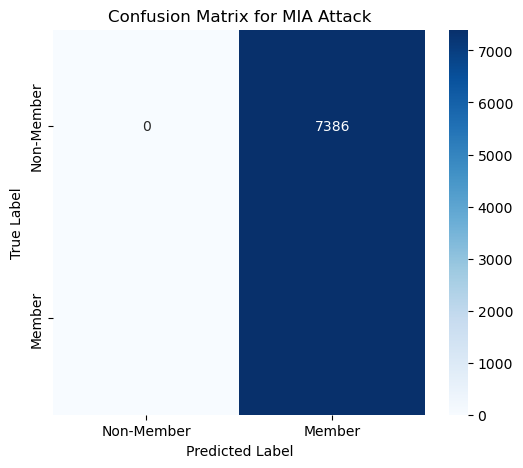

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(true_labels, attack_predictions)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Member", "Member"], yticklabels=["Non-Member", "Member"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for MIA Attack")
plt.show()
